In [40]:
from snowpack_functions import mesh_gridify,make_map
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
## do all basins in one. 
## one figure: fire risk in all five basins 
## each figure: 1970-1999, 2010-2039, 2040-2069,2070-2099 (1 x 4) 
'''
basins = ['cascades','california','northernrockies','southernrockies','whites']
scenarios = ['historical','rcp45','rcp45,'rcp45','historical','rcp85','rcp85','rcp85']
chunks = ['1970-1999','2010-2039','2040-2069','2070-2099','1970-1999',2010-2039','2040-2069','2070-2099']
'''
chunk = "1970-1999"
scenario = "historical"
basin = "california"
### load data 
direc = '/raid9/gergel/agg_snowpack/%s/' %scenario
filename = "moistdef_%s_%s.npz" %(chunk,basin)
data = np.load(os.path.join(direc,filename))
lats = data['lats'] # (#lats,)
lons = data['lons'] # (#lats,)
pet = data['pet'][:,:,0]
#pet = pet[:,0,:,0] # (#lats,)
aet = data['aet'][:,0,:,0] # (#lats,)
coms = data['coms'] ## centers of mass (#lats,30)


In [41]:
def early_vs_late_moist_deficit_rev(pet,aet,coms):
    perc_diffs = list()
    for gridcell in np.arange(len(pet)):
        ex_pet = pet[gridcell,:]
        ex_aet = aet[gridcell,:]
        ## subtract aet from pet to get cumulative moisture difference 
        pet_minus_aet = ex_pet - ex_aet 
        ex_coms = coms[gridcell,:]
        ## sort pet_minus_aet in terms of coms 
        pet_minus_aet_sorted = [x for (y,x) in sorted(zip(ex_coms,pet_minus_aet))]
        early_diff = pet_minus_aet_sorted[2] #3
        late_diff = pet_minus_aet_sorted[28] #27
        ## percent difference between early and late snowmelt years
        # perc_diff = (early_diff - late_diff)/early_diff
        perc_diff = (early_diff - late_diff)/((early_diff + late_diff)/2)
        # perc_diffs.append(perc_diff[0])
        perc_diffs.append(perc_diff)
    defs = np.asarray(perc_diffs)
    return(defs.reshape(len(defs),))

In [42]:
def snowmelt_years(coms):
    s_days = list()
    for gridcell in np.arange(len(coms)):
        coms_gridcell = coms[gridcell,:]
        coms_sorted = sorted(coms_gridcell)
        no_days = coms_sorted[28] - coms_sorted[2]
        s_days.append(no_days)
    numdays = np.asarray(s_days)
    return(numdays.reshape(len(numdays),))

In [43]:
def early_vs_late_moist_deficit(pet,aet,coms):
    perc_diffs = list()
    for gridcell in np.arange(len(pet)):
        ex_pet = pet[gridcell,:]
        ex_aet = aet[gridcell,:]
        ## subtract aet from pet to get cumulative moisture difference 
        pet_minus_aet = ex_pet - ex_aet 
        ex_coms = coms[gridcell,:]
        mean_com = np.mean(ex_coms)
        std_com = np.std(ex_coms)
        late_ind = np.where(ex_coms >= mean_com + 2*std_com)
        early_ind = np.where(ex_coms <= mean_com - 2*std_com)
        #################################if no +2 sigma COMs, take the maximum COM of the time series
        if len(late_ind[0]) == 0: 
            late_ind = np.argmax(ex_coms)
            late_diff = pet_minus_aet[late_ind]
        ################################# if more than 1 +2 sigma COMs, take the smaller one
        elif (len(late_ind[0]) > 1):
            late_diff = np.min(pet_minus_aet[late_ind])
        ################################# otherwise, take the one index
        else: 
            late_diff = pet_minus_aet[late_ind]

        #################################if no +2 sigma COMs, take the minimum COM of the time series
        if len(early_ind[0]) == 0:
            early_ind = np.argmin(ex_coms)
            early_diff = pet_minus_aet[early_ind]
        ################################# if more than 1 -2 sigma COMs, take the larger one, otherwise, take the index of the one
        elif (len(early_ind[0]) > 1):
            early_diff = np.max(pet_minus_aet[early_ind])
        ################################# otherwise, take the one index
        else: 
            early_diff = pet_minus_aet[early_ind]
        ## percent difference between early and late snowmelt years
        # perc_diff = (early_diff - late_diff)/early_diff
        perc_diff = (early_diff - late_diff)/((early_diff + late_diff)/2)
        # perc_diffs.append(perc_diff[0])
        perc_diffs.append(perc_diff)
    defs = np.asarray(perc_diffs)
    return(defs.reshape(len(defs),))

saving figure to /raid9/gergel/agg_snowpack/fire_risk/plots/fire_risk


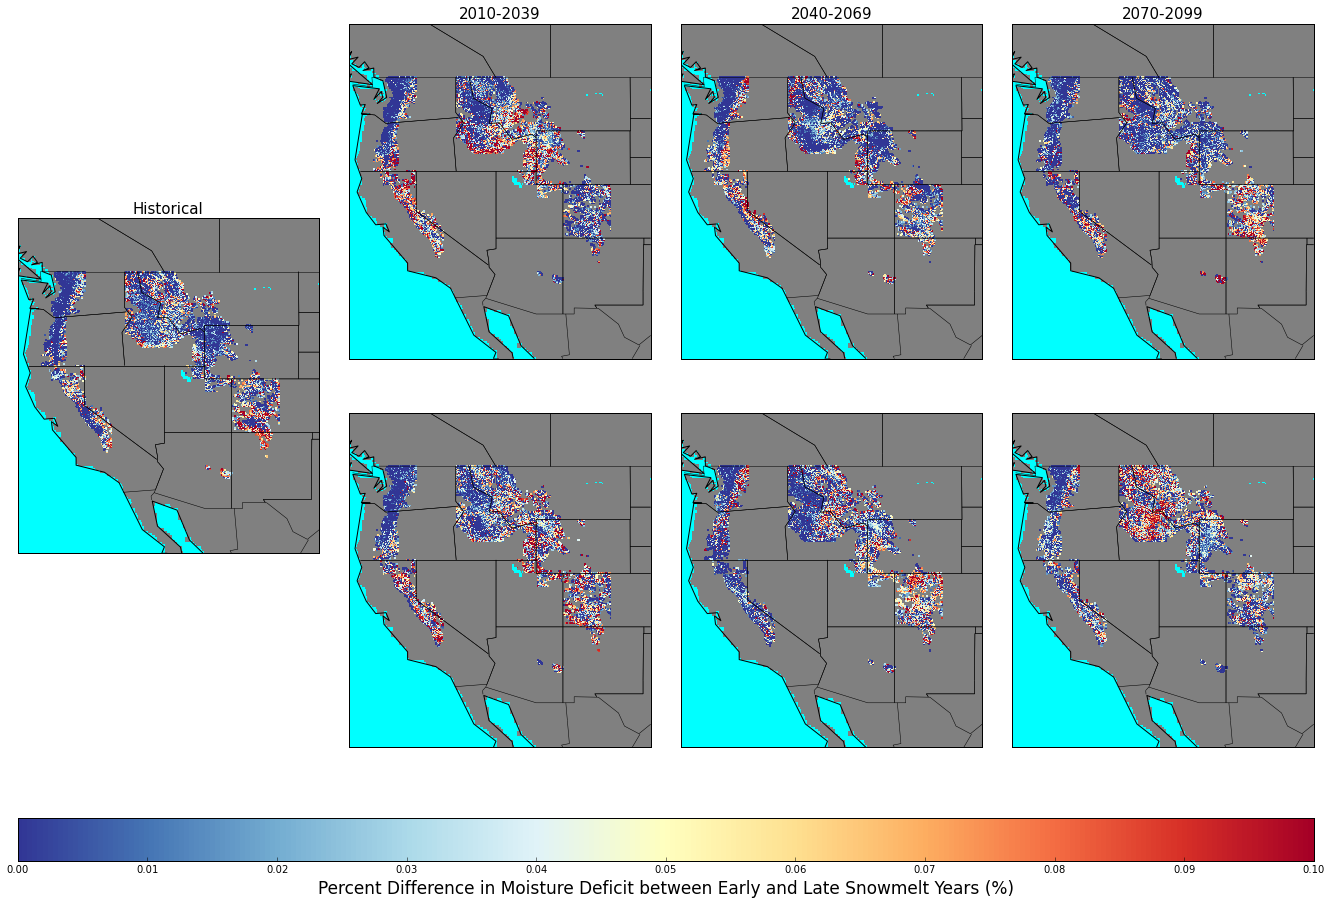

In [56]:
from pylab import *
lt = 18
rt = 12
fig = plt.figure(figsize=(lt,rt))
basins = ['cascades','california','northernrockies','southernrockies','whites']
# scenarios = ['historical','rcp45','rcp45','rcp45','historical','rcp85','rcp85','rcp85']
scenarios = ['rcp45','rcp45','rcp45','rcp85','rcp85','rcp85','historical']
# chunks = ['1970-1999','2010-2039','2040-2069','2070-2099','1970-1999','2010-2039','2040-2069','2070-2099']
chunks = ['2010-2039','2040-2069','2070-2099','2010-2039','2040-2069','2070-2099','1970-1999']
sps = np.asarray([2,3,4,6,7,8,9])
for num in np.arange(len(chunks)):
    if sps[num] < 9: 
        ax = fig.add_subplot(2,4,sps[num])
    else: 
        ax = fig.add_subplot(1,4,1)
        ax.set_title('Historical',fontsize=15)
    m = make_map()
    if sps[num] < 6:
        ax.set_title(chunks[num],fontsize=15)
    for basin in basins: 
        ## get data 
        direc = '/raid9/gergel/agg_snowpack/%s/' %scenarios[num]
        filename = "moistdef_%s_%s.npz" %(chunks[num],basin)
        data = np.load(os.path.join(direc,filename))
        lats_inc = data['lats']
        lons_inc = data['lons']
        pet = data['pet'][:,:,0] # (#lats,)
        aet = data['aet'][:,0,:,0] # (#lats,)
        coms = data['coms'] ## centers of mass (#lats,30)
        # var_series = np.divide(aet,pet)
        # var_series = np.subtract(pet,aet)
        var_series = early_vs_late_moist_deficit_rev(pet,aet,coms)
        lons_mesh,lats_mesh,data_mesh = mesh_gridify(lats_inc.reshape(len(lats_inc),1),lons_inc.reshape(len(lats_inc),1),var_series.reshape(len(lats_inc),1)) 
        cs = m.pcolormesh(lons_mesh,lats_mesh,data_mesh,shading='flat',cmap='RdYlBu_r',latlon=True,zorder=1,vmin=0,vmax=0.10)
        # cs = m.pcolormesh(lons_mesh,lats_mesh,data_mesh,shading='flat',cmap='RdYlBu',latlon=True,zorder=1,vmin=800,vmax=2500)
fig.subplots_adjust(left=0,right=1,top=1,bottom=0.1,hspace=0.00000001,wspace=0.1)
cax = fig.add_axes([0.0, 0.0, 1.0, 0.05])
cb = colorbar(cax=cax,orientation='horizontal')
cb.set_label('Percent Difference in Moisture Deficit between Early and Late Snowmelt Years (%)',size=17)
## save figure
direc = '/raid9/gergel/agg_snowpack/fire_risk/plots'
plotname = 'fire_risk' 
savepath = os.path.join(direc,plotname)
print("saving figure to %s" %savepath)
plt.savefig(savepath)

saving figure to /raid9/gergel/agg_snowpack/fire_risk/plots/fire_risk


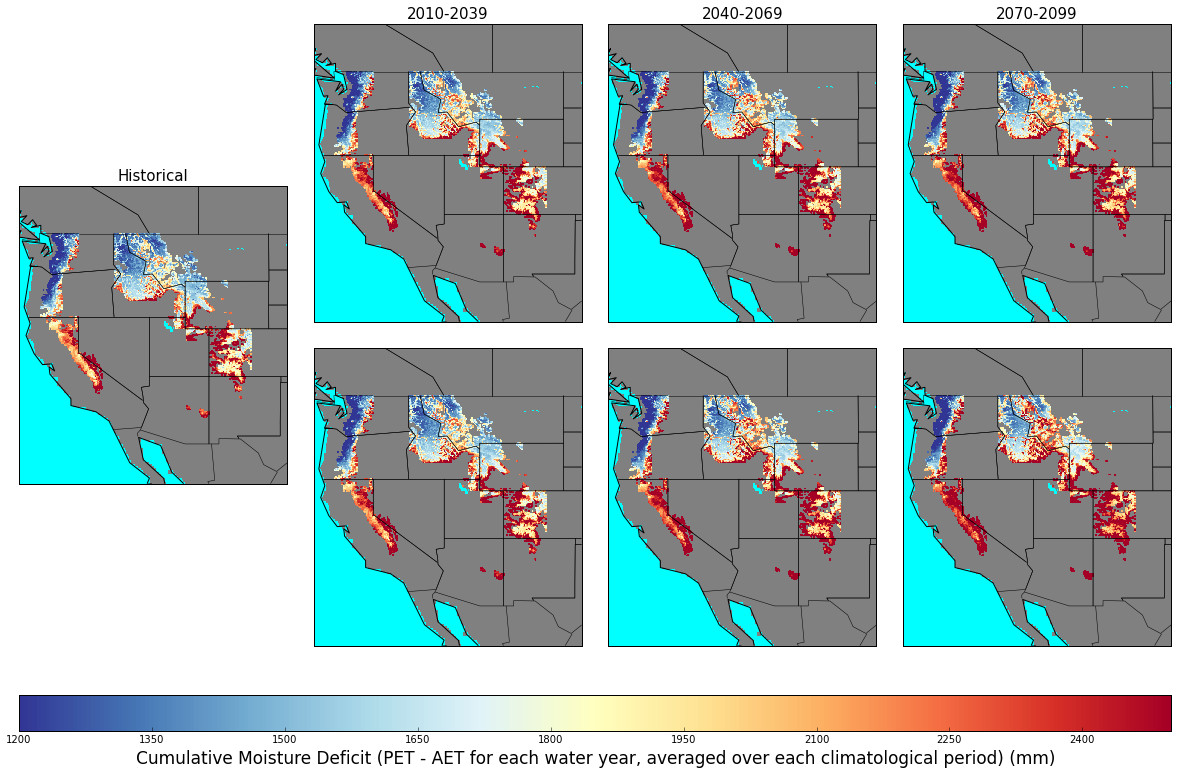

In [55]:
from pylab import *
lt = 16
rt = 10
fig = plt.figure(figsize=(lt,rt))
basins = ['cascades','california','northernrockies','southernrockies','whites']
# scenarios = ['historical','rcp45','rcp45','rcp45','historical','rcp85','rcp85','rcp85']
scenarios = ['rcp45','rcp45','rcp45','rcp85','rcp85','rcp85','historical']
# chunks = ['1970-1999','2010-2039','2040-2069','2070-2099','1970-1999','2010-2039','2040-2069','2070-2099']
chunks = ['2010-2039','2040-2069','2070-2099','2010-2039','2040-2069','2070-2099','1970-1999']
sps = np.asarray([2,3,4,6,7,8,9])
for num in np.arange(len(chunks)):
    if sps[num] < 9: 
        ax = fig.add_subplot(2,4,sps[num])
    else: 
        ax = fig.add_subplot(1,4,1)
        ax.set_title('Historical',fontsize=15)
    m = make_map()
    if sps[num] < 6:
        ax.set_title(chunks[num],fontsize=15)
    for basin in basins: 
        ## get data 
        direc = '/raid9/gergel/agg_snowpack/%s/' %scenarios[num]
        filename = "moistdef_%s_%s.npz" %(chunks[num],basin)
        data = np.load(os.path.join(direc,filename))
        lats_inc = data['lats']
        lons_inc = data['lons']
        pet = data['pet'][:,:,0] # (#lats,)
        aet = data['aet'][:,0,:,0] # (#lats,)
        coms = data['coms'] ## centers of mass (#lats,30)
        # var_series = np.divide(aet,pet)
        var_series = np.mean(pet,axis=1) - np.mean(aet,axis=1)
        # print(np.nanmean(var_series))
        # print(np.mean(coms,axis=1))
        #var_series = early_vs_late_moist_deficit(pet,aet,coms)
        lons_mesh,lats_mesh,data_mesh = mesh_gridify(lats_inc.reshape(len(lats_inc),1),lons_inc.reshape(len(lats_inc),1),var_series.reshape(len(lats_inc),1)) 
        cs = m.pcolormesh(lons_mesh,lats_mesh,data_mesh,shading='flat',cmap='RdYlBu_r',latlon=True,zorder=1,vmin=1200,vmax=2500)
        # cs = m.pcolormesh(lons_mesh,lats_mesh,data_mesh,shading='flat',cmap='RdYlBu',latlon=True,zorder=1,vmin=800,vmax=2500)
fig.subplots_adjust(left=0,right=1,top=1,bottom=0.1,hspace=0.00000001,wspace=0.1)
cax = fig.add_axes([0.0, 0.0, 1.0, 0.05])
cb = colorbar(cax=cax,orientation='horizontal')
cb.set_label('Cumulative Moisture Deficit (PET - AET for each water year, averaged over each climatological period) (mm)',size=17)
## save figure
direc = '/raid9/gergel/agg_snowpack/fire_risk/plots'
plotname = 'fire_risk' 
savepath = os.path.join(direc,plotname)
print("saving figure to %s" %savepath)
plt.savefig(savepath)

saving figure to /raid9/gergel/agg_snowpack/fire_risk/plots/snowmeltyears


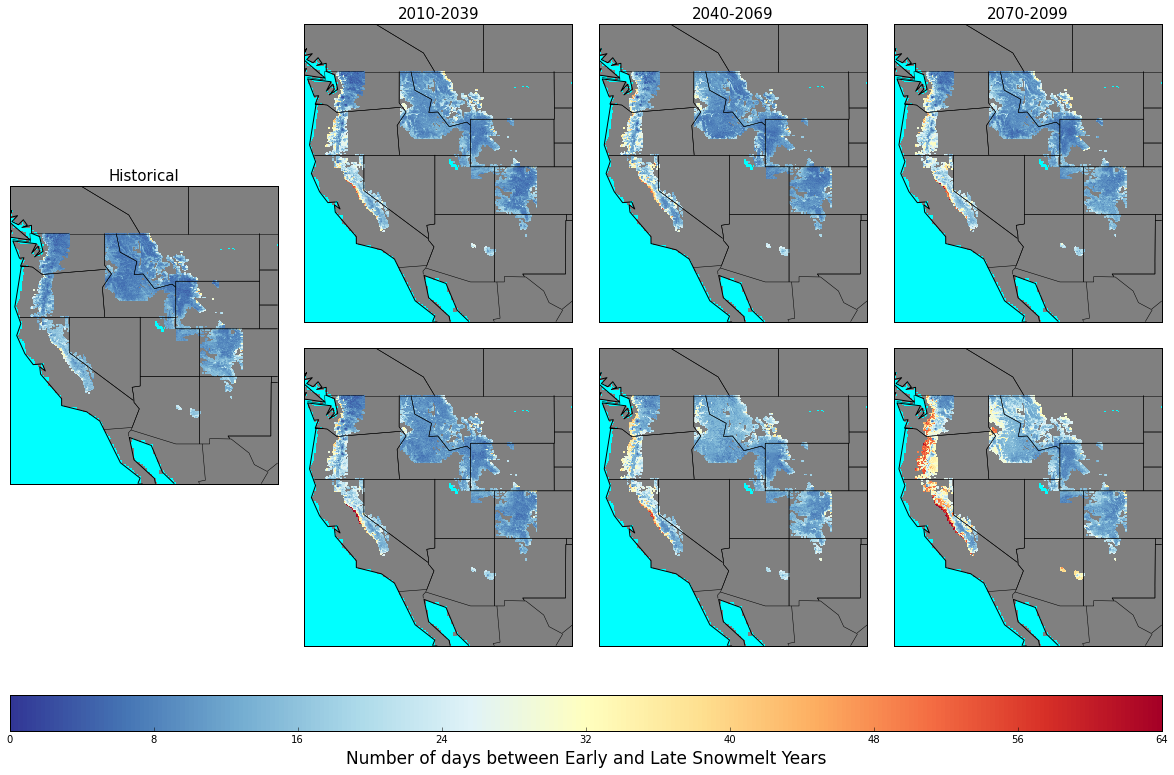

In [54]:
from pylab import *
lt = 16
rt = 10
fig = plt.figure(figsize=(lt,rt))
basins = ['cascades','california','northernrockies','southernrockies','whites']
# scenarios = ['historical','rcp45','rcp45','rcp45','historical','rcp85','rcp85','rcp85']
scenarios = ['rcp45','rcp45','rcp45','rcp85','rcp85','rcp85','historical']
# chunks = ['1970-1999','2010-2039','2040-2069','2070-2099','1970-1999','2010-2039','2040-2069','2070-2099']
chunks = ['2010-2039','2040-2069','2070-2099','2010-2039','2040-2069','2070-2099','1970-1999']
sps = np.asarray([2,3,4,6,7,8,9])
for num in np.arange(len(chunks)):
    # ax = fig.add_subplot(1,4,num+1)
    if sps[num] < 9: 
        ax = fig.add_subplot(2,4,sps[num])
    else: 
        ax = fig.add_subplot(1,4,1)
        ax.set_title('Historical',fontsize=15)
    m = make_map()
    if sps[num] < 6:
        ax.set_title(chunks[num],fontsize=15)
    for basin in basins: 
        ## get data 
        direc = '/raid9/gergel/agg_snowpack/%s/' %scenarios[num]
        filename = "moistdef_%s_%s.npz" %(chunks[num],basin)
        data = np.load(os.path.join(direc,filename))
        lats_inc = data['lats']
        lons_inc = data['lons']
        pet = data['pet'][:,:,0] # (#lats,)
        aet = data['aet'][:,0,:,0] # (#lats,)
        coms = data['coms'] ## centers of mass (#lats,30)
        # var_series = np.divide(aet,pet)
        # var_series = np.mean(pet,axis=1) - np.mean(aet,axis=1)
        var_series = snowmelt_years(coms)
        lons_mesh,lats_mesh,data_mesh = mesh_gridify(lats_inc.reshape(len(lats_inc),1),lons_inc.reshape(len(lats_inc),1),var_series.reshape(len(lats_inc),1)) 
        cs = m.pcolormesh(lons_mesh,lats_mesh,data_mesh,shading='flat',cmap='RdYlBu_r',latlon=True,zorder=1,vmin=0,vmax=64)
fig.subplots_adjust(left=0,right=1,top=1,bottom=0.1,hspace=0.00000001,wspace=0.1)
cax = fig.add_axes([0.0, 0.0, 1.0, 0.05])
cb = colorbar(cax=cax,orientation='horizontal')
cb.set_label('Number of days between Early and Late Snowmelt Years',size=17)
## save figure
direc = '/raid9/gergel/agg_snowpack/fire_risk/plots'
plotname = 'snowmeltyears' 
savepath = os.path.join(direc,plotname)
print("saving figure to %s" %savepath)
plt.savefig(savepath)